In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.python.client import device_lib
from nltk.tokenize import word_tokenize
import time
import collections
import csv
import re
import os
import matplotlib.pyplot as plt
import pylab
import json

In [ ]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
HIDDEN_SIZE = 20
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
EMBEDDING_SIZE = 20

batch_size = 128
no_epochs = 250
lr = 0.01
use_dropout = False

seed = 10
tf.random.set_seed(seed)

In [ ]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpus)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        devices = device_lib.list_local_devices()
        avail_gpu = [x for x in devices if x.device_type == 'GPU']
        print('\n',avail_gpu)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No gpus available")

In [ ]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [ ]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

In [ ]:
def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

In [ ]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./data/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./data/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))
            
    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1

    return x_train, y_train, x_test, y_test, vocab_size

In [ ]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

In [ ]:
def load_history(model_name, dropout):
    if dropout:
        with open(f'./histories/{model_name}_dropout') as file:
            history = json.load(file)
    else:
        with open(f'./histories/{model_name}_nodropout') as file:
            history = json.load(file)
    return history

In [ ]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [ ]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [ ]:
class WordRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        
    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)

        return logits

In [ ]:
x_train, y_train, x_test, y_test, vocab_size = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Build model
tf.keras.backend.set_floatx('float32')
model = WordRNN(vocab_size, hidden_dim=HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
print(vocab_size)

In [14]:
name = 'WordRNN'

test_acc = []
train_acc = []
test_l = []
train_l = []

start_time = time.time()

drop_rate = 0.5 if use_dropout else 0
print(drop_rate)

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate)  # drop_rate=0 iff not DO_Q5 change to 0.5 for Q5

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate)   # drop_rate=0 iff not DO_Q5 change to 0.5 for Q5

    test_acc.append(test_accuracy.result().numpy().astype(float))
    train_acc.append(train_accuracy.result().numpy().astype(float))
    test_l.append(test_loss.result().numpy().astype(float))
    train_l.append(train_loss.result().numpy().astype(float))

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result())
    print(template)

time_taken = time.time() - start_time

0
Epoch 1, Loss: 2.6653292179107666, Accuracy: 0.07035714387893677, Test Loss: 2.6457607746124268, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.646775960922241, Accuracy: 0.07410714030265808, Test Loss: 2.6485116481781006, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6001689434051514, Accuracy: 0.09982142597436905, Test Loss: 2.3566672801971436, Test Accuracy: 0.14142857491970062
Epoch 4, Loss: 1.9115647077560425, Accuracy: 0.2766071557998657, Test Loss: 1.5456427335739136, Test Accuracy: 0.40857142210006714
Epoch 5, Loss: 1.1610705852508545, Accuracy: 0.5683928728103638, Test Loss: 1.0986824035644531, Test Accuracy: 0.618571400642395
Epoch 6, Loss: 0.6671999096870422, Accuracy: 0.7808928489685059, Test Loss: 0.8069193959236145, Test Accuracy: 0.7485714554786682
Epoch 7, Loss: 0.3415164351463318, Accuracy: 0.904285728931427, Test Loss: 0.662455141544342, Test Accuracy: 0.8142856955528259
Epoch 8, Loss: 0.16446898877620697, Accuracy: 0.9616071581840515, Test Loss: 0.57732897

Epoch 65, Loss: 0.00023673112445976585, Accuracy: 1.0, Test Loss: 0.8158650398254395, Test Accuracy: 0.868571400642395
Epoch 66, Loss: 0.00022720778360962868, Accuracy: 1.0, Test Loss: 0.8209330439567566, Test Accuracy: 0.8671428561210632
Epoch 67, Loss: 0.0002179313451051712, Accuracy: 1.0, Test Loss: 0.8258364200592041, Test Accuracy: 0.8671428561210632
Epoch 68, Loss: 0.00020939134992659092, Accuracy: 1.0, Test Loss: 0.830659806728363, Test Accuracy: 0.8671428561210632
Epoch 69, Loss: 0.00020155907259322703, Accuracy: 1.0, Test Loss: 0.8353777527809143, Test Accuracy: 0.8671428561210632
Epoch 70, Loss: 0.00019394519040361047, Accuracy: 1.0, Test Loss: 0.8402121663093567, Test Accuracy: 0.8671428561210632
Epoch 71, Loss: 0.00018697501218412071, Accuracy: 1.0, Test Loss: 0.8447868227958679, Test Accuracy: 0.868571400642395
Epoch 72, Loss: 0.00018020985589828342, Accuracy: 1.0, Test Loss: 0.8492395877838135, Test Accuracy: 0.868571400642395
Epoch 73, Loss: 0.00017371572903357446, Accur

Epoch 134, Loss: 3.174257290083915e-05, Accuracy: 1.0, Test Loss: 1.0601369142532349, Test Accuracy: 0.8714285492897034
Epoch 135, Loss: 3.0940052965888754e-05, Accuracy: 1.0, Test Loss: 1.0624388456344604, Test Accuracy: 0.8700000047683716
Epoch 136, Loss: 3.0232920835260302e-05, Accuracy: 1.0, Test Loss: 1.0661559104919434, Test Accuracy: 0.8700000047683716
Epoch 137, Loss: 2.947653592855204e-05, Accuracy: 1.0, Test Loss: 1.0689491033554077, Test Accuracy: 0.8700000047683716
Epoch 138, Loss: 2.8781272703781724e-05, Accuracy: 1.0, Test Loss: 1.0719329118728638, Test Accuracy: 0.8700000047683716
Epoch 139, Loss: 2.8085372832720168e-05, Accuracy: 1.0, Test Loss: 1.0749070644378662, Test Accuracy: 0.8700000047683716
Epoch 140, Loss: 2.7445068553788587e-05, Accuracy: 1.0, Test Loss: 1.0774935483932495, Test Accuracy: 0.8700000047683716
Epoch 141, Loss: 2.6774609068525024e-05, Accuracy: 1.0, Test Loss: 1.0810575485229492, Test Accuracy: 0.8700000047683716
Epoch 142, Loss: 2.613696960906963

Epoch 203, Loss: 6.270523499551928e-06, Accuracy: 1.0, Test Loss: 1.2883999347686768, Test Accuracy: 0.8614285588264465
Epoch 204, Loss: 6.131665941211395e-06, Accuracy: 1.0, Test Loss: 1.291871190071106, Test Accuracy: 0.8614285588264465
Epoch 205, Loss: 5.9897110986639746e-06, Accuracy: 1.0, Test Loss: 1.2953240871429443, Test Accuracy: 0.8614285588264465
Epoch 206, Loss: 5.8494292716204654e-06, Accuracy: 1.0, Test Loss: 1.2989963293075562, Test Accuracy: 0.8614285588264465
Epoch 207, Loss: 5.7177544476871844e-06, Accuracy: 1.0, Test Loss: 1.3025131225585938, Test Accuracy: 0.8614285588264465
Epoch 208, Loss: 5.590476121142274e-06, Accuracy: 1.0, Test Loss: 1.305985450744629, Test Accuracy: 0.8614285588264465
Epoch 209, Loss: 5.466415586852236e-06, Accuracy: 1.0, Test Loss: 1.3095110654830933, Test Accuracy: 0.8614285588264465
Epoch 210, Loss: 5.338119990483392e-06, Accuracy: 1.0, Test Loss: 1.3132028579711914, Test Accuracy: 0.8614285588264465
Epoch 211, Loss: 5.218882961344207e-06,

In [15]:
print(time_taken)

2691.319160461426


In [16]:
history = {name: {
    'accuracy': train_acc,
    'val_acc': test_acc,
    'loss': train_l,
    'val_loss': test_l,
    'time_taken': time_taken
}}

if use_dropout:
    with open(f'./histories/{name}_dropout', 'w') as file:
        json.dump(history, file)
else:
    with open(f'./histories/{name}_nodropout', 'w') as file:
        json.dump(history, file)

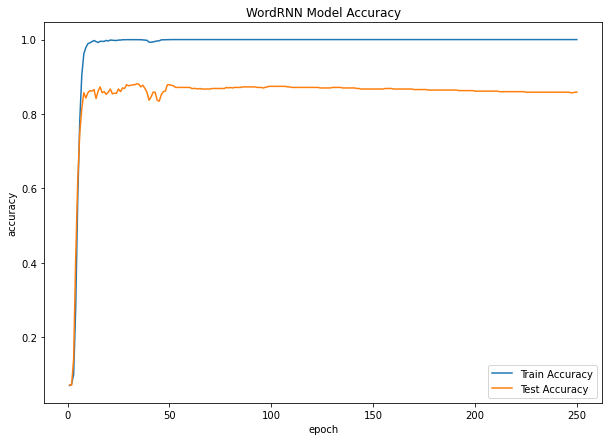

In [17]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['accuracy'], label='Train Accuracy')
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['val_acc'], label='Test Accuracy')
plt.title(f'{name} Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
if use_dropout:
    plt.savefig(
            f'./results/QuestionB4_{name}_accuracy_dropout.pdf'
        )
else:
    plt.savefig(
            f'./results/QuestionB4_{name}_accuracy_nodropout.pdf'
        )

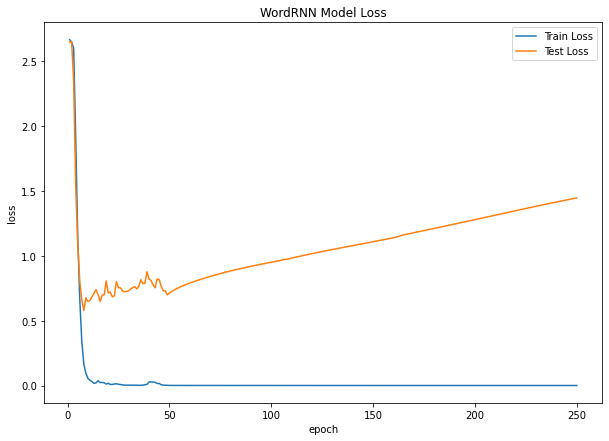

In [18]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['loss'], label='Train Loss')
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['val_loss'], label='Test Loss')
plt.title(f'{name} Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
if use_dropout:
    plt.savefig(
            f'./results/QuestionB4_{name}_loss_dropout.pdf'
        )
else:
    plt.savefig(
            f'./results/QuestionB4_{name}_loss_nodropout.pdf'
        )